In [1]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
vis = ['GRVI', 'NDVI', 'EVI', 'KTTC_GRN', 'RSR', 'NDII', 'NBR', 'KTTC_WET']
nvis = len(vis)
photosyn_vis = ['GRVI', 'NDVI', 'EVI', 'KTTC_GRN']
moisture_vis = ['RSR', 'NDII', 'NBR', 'KTTC_WET']
sites = ['CHITTY', 'KLOO', 'SILVER', 'SULPHUR']

In [3]:
fname = 'Masting_VI_Regressions_Table.csv'
masting_df = pd.read_csv(fname)
masting_df.drop(columns=['cone_count_stdv', 'mast_rel_year'], inplace=True)
for vi in vis:
    masting_df.drop(columns=['%s_intercept' % vi.lower()], inplace=True)

In [4]:
masting_df['site_idx'] = [sites.index(site_name) for site_name in masting_df['site_name']]
for vi in vis:
    mean = masting_df['%s_slope' % vi.lower()].mean()
    stdv = masting_df['%s_slope' % vi.lower()].std()
    masting_df['%s_slope_sds' % vi.lower()] = (masting_df['%s_slope' % vi.lower()] - mean) / stdv
    masting_df.drop(columns=['%s_slope' % vi.lower()], inplace=True)
masting_df

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,nbr_slope_sds,kttc_wet_slope_sds
0,CHITTY,1991,0,0,-0.829970,0.395818,0.562327,0.291268,0.928034,-0.246019,-0.102297,-0.487206
1,CHITTY,1992,0,0,0.314277,-0.283064,0.159866,0.099029,0.131635,0.647337,0.561732,0.516141
2,CHITTY,1993,0,0,-0.483825,-0.065527,-0.615358,-0.581983,0.243178,-2.362150,-1.916494,-1.660138
3,CHITTY,1994,0,0,0.986045,0.449790,0.667906,0.496778,-0.111049,0.308962,0.554189,-0.135059
4,CHITTY,1996,0,0,0.994249,0.592172,0.425852,0.375119,-0.019742,0.866513,0.935755,0.556554
...,...,...,...,...,...,...,...,...,...,...,...,...
96,SULPHUR,2013,0,3,0.271716,0.894232,-0.014425,0.115988,-0.264852,0.553423,0.365757,0.185171
97,SULPHUR,2014,1,3,0.446133,0.172943,0.013885,-0.063112,0.102800,0.362702,0.376059,0.047183
98,SULPHUR,2015,0,3,0.323242,0.813421,0.329445,0.400376,0.406497,0.565979,0.579099,0.062169
99,SULPHUR,2016,0,3,-0.103053,0.392447,0.071401,0.060286,0.044753,0.160579,0.067463,-0.022664


In [5]:
print('dataset contains %d site-years' % len(masting_df))
print('                 %d mast years' % sum(masting_df['mast_year']))

dataset contains 101 site-years
                 16 mast years


In [6]:
def corr_heatmap(df, vis, outfname=None):
    nvis = len(vis)
    corr_cols = ['%s_slope_sds' % vi.lower() for vi in vis]
    corr_df = df.filter(corr_cols, axis=1)
    corr_matrix = corr_df.corr()
    sns.set(style="white")
    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
    for i in range(nvis):
        mask[i, i] = False
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0.0,
                square=True, annot=True, linewidths=.5, cbar_kws={"shrink" : 0.75})
    plt.xticks(ticks=[x+0.5 for x in range(nvis)], labels=vis, ha='center')
    plt.yticks(ticks=[y+0.5 for y in range(nvis)], labels=vis, va='center')
    if outfname:
        plt.savefig(outfname, dpi=300, bbox_inches='tight')
    return corr_matrix

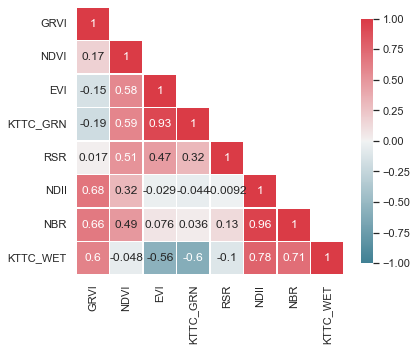

In [7]:
corr_matrix = corr_heatmap(masting_df, vis, 'VI_correlation_matrix_color.png')

In [8]:
models = ['1']
nparams = [3]
for vi in vis:
    models.append('%s_slope_sds' % vi.lower())
    nparams.append(4)
for i in range(2, nvis):
    combs = combinations(vis, i)
    for comb in list(combs):
        model_str = ''
        for vi in comb[:-1]:
            model_str += '%s_slope_sds + ' % vi.lower()
        model_str += '%s_slope_sds' % comb[-1].lower()
        models.append(model_str)
        nparams.append(i+3)
model_str = ''
for vi in vis[:-1]:
    model_str += '%s_slope_sds + ' % vi.lower()
model_str += '%s_slope_sds' % vis[-1].lower()
models.append(model_str)
nparams.append(nvis+3)
print('%d unique models identified' % len(models))
#
prsq = list()
aicc = list()
acc = list()
kappa = list()
ncorrect = list()
nmissed = list()
nfalse = list()
for i, model in enumerate(models):
    lf = 'mast_year ~ %s + (1|year) + (1|site_idx)' % model
    lm = smf.logit(lf, masting_df)
    try:
        lr = lm.fit(maxiter=1000)
        prsq.append(lr.prsquared)
        nk = nparams[i]
        nobs = len(masting_df)
        aic_corr = lr.aic + (2 * nk * (nk - 1) / (nobs - nk - 1))
        aicc.append(aic_corr)
        pred_table = lr.pred_table()
        accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
        acc.append(accuracy)
        k = cohen_kappa_score(masting_df['mast_year'], np.round(lr.predict()).astype(int))
        kappa.append(k)
        ncorrect.append(pred_table[1, 1])
        nmissed.append(pred_table[1, 0])
        nfalse.append(pred_table[0, 1])
    except:
        prsq.append(np.nan)
        aicc.append(np.nan)
        acc.append(np.nan)
        kappa.append(np.nan)
        ncorrect.append(np.nan)
        nmissed.append(np.nan)
        nfalse.append(np.nan)
daicc = list()
weight = list()
for val in aicc:
    diff = val - np.nanmin(aicc)
    if diff <= 2.0:
        daicc.append(diff)
        weight.append(np.exp(-0.5 * diff))
    else:
        daicc.append(np.nan)
        weight.append(np.nan)
weight /= np.nansum(weight)

256 unique models identified
Optimization terminated successfully.
         Current function value: 0.432105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411105
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386147
         Iterations 7
Optimization terminated successfully.
         Curren

Optimization terminated successfully.
         Current function value: 0.334704
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330842
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.343676
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.375932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332517
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.377426
  

Optimization terminated successfully.
         Current function value: 0.360600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334514
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.321590
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.325171
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.346794
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346241
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331221
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.322656
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.341971
  

Optimization terminated successfully.
         Current function value: 0.312275
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.312974
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309840
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.344031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.321898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309554
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.315332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309326
         Iterations 9


In [9]:
df = pd.DataFrame({'model' : models, 'pseudo-R2' : prsq, 'AICc' : aicc,
                   'dAICc' : daicc, 'weight' : weight, 'n_correct' : ncorrect,
                   'n_missed' : nmissed, 'n_false' : nfalse, 'Accuracy' : acc,
                   'kappa' : kappa})
trim_df = df[df['AICc'] <= (df['AICc'].min() + 2)]
trim_df = trim_df.sort_values(by=['AICc', 'kappa'], ascending=[True, False])
trim_df

,model,pseudo-R2,AICc,dAICc,weight,n_correct,n_missed,n_false,Accuracy,kappa
32,rsr_slope_sds + nbr_slope_sds,0.234787,77.974643,0.000000,0.177028,3.0,13.0,1.0,0.861386,0.252643
53,grvi_slope_sds + rsr_slope_sds + nbr_slope_sds,0.251892,78.681901,0.707258,0.124297,4.0,12.0,0.0,0.881188,0.359408
68,ndvi_slope_sds + rsr_slope_sds + nbr_slope_sds,0.251081,78.753454,0.778810,0.119929,3.0,13.0,1.0,0.861386,0.252643
149,evi_slope_sds + kttc_grn_slope_sds + rsr_slope...,0.269790,79.366768,1.392125,0.088256,3.0,13.0,3.0,0.841584,0.203941
31,rsr_slope_sds + ndii_slope_sds,0.218977,79.370405,1.395761,0.088096,2.0,14.0,2.0,0.841584,0.145877
150,evi_slope_sds + kttc_grn_slope_sds + rsr_slope...,0.269518,79.390791,1.416148,0.087202,3.0,13.0,5.0,0.821782,0.161439
84,kttc_grn_slope_sds + rsr_slope_sds + nbr_slope...,0.242983,79.468362,1.493718,0.083885,3.0,13.0,1.0,0.861386,0.252643
148,evi_slope_sds + kttc_grn_slope_sds + rsr_slope...,0.268557,79.475615,1.500972,0.083581,3.0,13.0,4.0,0.831683,0.181991
79,evi_slope_sds + rsr_slope_sds + kttc_wet_slope...,0.241013,79.642250,1.667607,0.076900,3.0,13.0,2.0,0.851485,0.227435
91,rsr_slope_sds + nbr_slope_sds + kttc_wet_slope...,0.239149,79.806807,1.832164,0.070826,3.0,13.0,1.0,0.861386,0.252643


In [10]:
models = list(trim_df['model'])
nmodels = len(models)
models

['rsr_slope_sds + nbr_slope_sds',
 'grvi_slope_sds + rsr_slope_sds + nbr_slope_sds',
 'ndvi_slope_sds + rsr_slope_sds + nbr_slope_sds',
 'evi_slope_sds + kttc_grn_slope_sds + rsr_slope_sds + nbr_slope_sds',
 'rsr_slope_sds + ndii_slope_sds',
 'evi_slope_sds + kttc_grn_slope_sds + rsr_slope_sds + kttc_wet_slope_sds',
 'kttc_grn_slope_sds + rsr_slope_sds + nbr_slope_sds',
 'evi_slope_sds + kttc_grn_slope_sds + rsr_slope_sds + ndii_slope_sds',
 'evi_slope_sds + rsr_slope_sds + kttc_wet_slope_sds',
 'rsr_slope_sds + nbr_slope_sds + kttc_wet_slope_sds']

In [11]:
for i, model in enumerate(models):
    lf = 'mast_year ~ %s + (1|year) + (1|site_idx)' % model
    lm = smf.logit(lf, masting_df)
    lr = lm.fit(maxiter=1000)
    masting_df['model_%d_predicted' % (i+1)] = lr.predict()
combined_prediction = np.zeros_like(np.array(masting_df['model_1_predicted']))
weight = list(trim_df['weight'])
for i in range(nmodels):
    combined_prediction += weight[i] * np.array(masting_df['model_%d_predicted' % (i+1)])
masting_df['combined_model_predicted'] = np.round(combined_prediction).astype(int)

Optimization terminated successfully.
         Current function value: 0.334424
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.326949
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319126
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.341333
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319245
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330842
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319665
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332517
  

In [12]:
masting_df

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_2_predicted,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted
0,CHITTY,1991,0,0,-0.829970,0.395818,0.562327,0.291268,0.928034,-0.246019,...,0.154722,0.212337,0.179267,0.220200,0.167569,0.239774,0.143812,0.235913,0.256567,0
1,CHITTY,1992,0,0,0.314277,-0.283064,0.159866,0.099029,0.131635,0.647337,...,0.015192,0.010199,0.015598,0.016116,0.011476,0.016193,0.012083,0.013065,0.015022,0
2,CHITTY,1993,0,0,-0.483825,-0.065527,-0.615358,-0.581983,0.243178,-2.362150,...,0.387281,0.388804,0.304369,0.394350,0.451260,0.237343,0.384941,0.486545,0.310879,0
3,CHITTY,1994,0,0,0.986045,0.449790,0.667906,0.496778,-0.111049,0.308962,...,0.014880,0.012646,0.009203,0.016150,0.010737,0.012378,0.011399,0.013976,0.012312,0
4,CHITTY,1996,0,0,0.994249,0.592172,0.425852,0.375119,-0.019742,0.866513,...,0.014110,0.013087,0.011609,0.014290,0.009825,0.012561,0.011842,0.010603,0.011355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,SULPHUR,2013,0,3,0.271716,0.894232,-0.014425,0.115988,-0.264852,0.553423,...,0.038982,0.088353,0.047993,0.041126,0.058909,0.047939,0.046703,0.052086,0.044865,0
97,SULPHUR,2014,1,3,0.446133,0.172943,0.013885,-0.063112,0.102800,0.362702,...,0.154025,0.153071,0.112550,0.154332,0.166810,0.147796,0.121988,0.197776,0.161013,0
98,SULPHUR,2015,0,3,0.323242,0.813421,0.329445,0.400376,0.406497,0.565979,...,0.237358,0.320706,0.267229,0.244596,0.323487,0.290714,0.275618,0.301765,0.284207,0
99,SULPHUR,2016,0,3,-0.103053,0.392447,0.071401,0.060286,0.044753,0.160579,...,0.180810,0.274375,0.189223,0.203496,0.207061,0.222359,0.191071,0.222381,0.219580,0


In [13]:
pred_table = np.zeros((2,2)).astype(int)
pred_table[0, 0] = len(masting_df[masting_df['mast_year'] + masting_df['combined_model_predicted'] == 0])
pred_table[0, 1] = len(masting_df[masting_df['combined_model_predicted'] - masting_df['mast_year'] == 1])
pred_table[1, 0] = len(masting_df[masting_df['mast_year'] - masting_df['combined_model_predicted'] == 1])
pred_table[1, 1] = len(masting_df[masting_df['mast_year'] + masting_df['combined_model_predicted'] == 2])
print(pred_table)
accuracy = (pred_table[0, 0] + pred_table[1, 1]) / np.sum(pred_table)
print('Overall accuracy: %.3f' % accuracy)
k = cohen_kappa_score(masting_df['mast_year'], masting_df['combined_model_predicted'])
print('Cohen\'s kappa: %.3f' % k)

[[84  1]
 [13  3]]
Overall accuracy: 0.861
Cohen's kappa: 0.253


In [14]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['combined_model_predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_2_predicted,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,...,0.852899,0.896247,0.669041,0.886503,0.723114,0.869227,0.709907,0.910594,0.904822,1
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,...,0.912331,0.761742,0.976509,0.414893,0.872279,0.897865,0.918487,0.545643,0.773198,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,...,0.904317,0.977534,0.958341,0.933985,0.967139,0.930975,0.978765,0.950480,0.932822,1


In [15]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['combined_model_predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_2_predicted,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,...,0.202932,0.308518,0.386731,0.224936,0.371604,0.263726,0.393634,0.246290,0.238539,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,...,0.110624,0.067846,0.088521,0.052684,0.236786,0.038188,0.088665,0.143436,0.050502,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,...,0.208684,0.173124,0.176750,0.240170,0.198141,0.196679,0.192539,0.240186,0.212851,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,...,0.132783,0.199235,0.309350,0.166692,0.267686,0.231079,0.285980,0.180993,0.198350,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,...,0.257267,0.375566,0.261777,0.319020,0.211918,0.295786,0.235948,0.283498,0.310036,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,...,0.330419,0.255830,0.186834,0.398281,0.156268,0.333610,0.231850,0.277337,0.339311,0
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,...,0.516894,0.357177,0.472675,0.401228,0.273776,0.416147,0.412262,0.273671,0.385811,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,...,0.225095,0.127510,0.190311,0.210242,0.168263,0.160413,0.197500,0.168807,0.166740,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,...,0.171349,0.195901,0.174586,0.249689,0.218892,0.155580,0.223585,0.236610,0.179911,0
81,SULPHUR,1998,1,3,0.356217,1.314904,0.343998,0.589226,0.817719,0.355528,...,0.117436,0.188217,0.181768,0.129850,0.194051,0.159776,0.198211,0.137849,0.141713,0


In [16]:
false_alarm = masting_df[masting_df['combined_model_predicted'] - masting_df['mast_year'] == 1]
false_alarm

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_2_predicted,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted
70,SILVER,2016,0,2,-1.583633,-0.998051,-0.806381,-0.729602,0.243857,-0.773358,...,0.426215,0.493812,0.574112,0.552985,0.522156,0.543866,0.538715,0.539002,0.55758,1


In [17]:
lf = 'mast_year ~ %s + (1|year) + (1|site_idx)' % trim_df['model'].loc[32]
print(lf)
lm = smf.logit(lf, masting_df)
lr = lm.fit(maxiter=1000)
print(lr.summary())
print()
print(lr.pred_table())
coeff_vals = list()
CI_low_vals = list()
CI_high_vals = list()
model_vis = ['_'.join(vi.split('_')[:-2]).upper() for vi in lf.split(' ~ ')[1].split(' + ')[:-2]]
for i, vi in enumerate(model_vis):
    coeff_vals.append(lr.params[i+1])
    CI_low_vals.append(lr.conf_int()[0]['%s_slope_sds' % vi.lower()])
    CI_high_vals.append(lr.conf_int()[1]['%s_slope_sds' % vi.lower()])

mast_year ~ rsr_slope_sds + nbr_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.334424
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            4
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                  0.2348
Time:                        13:23:50   Log-Likelihood:                -33.777
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                 0.0003586
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -258.0523    108.33

In [18]:
def plot_coefficients(labels, photosyn_vis, moisture_vis, coeff_vals, CI_low_vals, CI_high_vals, outfname):
    nlabels = len(labels)
    y = np.linspace(0, 1, nlabels+1)
    y_loc = [(yy + y[i+1]) / 2 for i, yy in enumerate(y[:-1])]
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6.5, (0.438333 * nlabels - 0.006667))
    for i, y in enumerate(y_loc):
        if labels[i] in moisture_vis:
            plt.plot([CI_low_vals[i], CI_high_vals[i]], [y, y], '-|', color='navy')
            plt.plot(coeff_vals[i], y, 'D', color='navy')
        elif labels[i] in photosyn_vis:
            plt.plot([CI_low_vals[i], CI_high_vals[i]], [y, y], '-|', color='darkgreen')
            plt.plot(coeff_vals[i], y, 'D', color='darkgreen')
    plt.plot([0, 0], [0, 1], '--k')
    plt.xlabel('Logistic regression coefficients', fontsize=12)
    plt.ylim([0, 1])
    ax1.set_ylabel('Landsat VI', fontsize=12)
    ax1.set_yticks(y_loc)
    ax1.set_yticklabels(labels, fontsize=12)
    plt.savefig(outfname, dpi=300, bbox_inches='tight')
    plt.show()

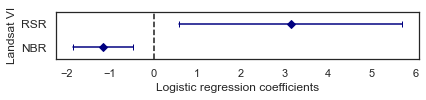

In [19]:
plot_coefficients(model_vis[::-1], photosyn_vis, moisture_vis, coeff_vals[::-1],
                  CI_low_vals[::-1], CI_high_vals[::-1], 'Model_32_logistic_coeffs_color.png')

In [20]:
accuracy = (lr.pred_table()[0,0] + lr.pred_table()[1,1]) / np.sum(lr.pred_table())
accuracy

0.8613861386138614

In [21]:
masting_df['predicted'] = np.round(lr.predict()).astype(int)

In [22]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted,predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,...,0.896247,0.669041,0.886503,0.723114,0.869227,0.709907,0.910594,0.904822,1,1
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,...,0.761742,0.976509,0.414893,0.872279,0.897865,0.918487,0.545643,0.773198,1,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,...,0.977534,0.958341,0.933985,0.967139,0.930975,0.978765,0.950480,0.932822,1,1


In [23]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted,predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,...,0.308518,0.386731,0.224936,0.371604,0.263726,0.393634,0.246290,0.238539,0,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,...,0.067846,0.088521,0.052684,0.236786,0.038188,0.088665,0.143436,0.050502,0,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,...,0.173124,0.176750,0.240170,0.198141,0.196679,0.192539,0.240186,0.212851,0,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,...,0.199235,0.309350,0.166692,0.267686,0.231079,0.285980,0.180993,0.198350,0,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,...,0.375566,0.261777,0.319020,0.211918,0.295786,0.235948,0.283498,0.310036,0,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,...,0.255830,0.186834,0.398281,0.156268,0.333610,0.231850,0.277337,0.339311,0,0
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,...,0.357177,0.472675,0.401228,0.273776,0.416147,0.412262,0.273671,0.385811,0,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,...,0.127510,0.190311,0.210242,0.168263,0.160413,0.197500,0.168807,0.166740,0,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,...,0.195901,0.174586,0.249689,0.218892,0.155580,0.223585,0.236610,0.179911,0,0
81,SULPHUR,1998,1,3,0.356217,1.314904,0.343998,0.589226,0.817719,0.355528,...,0.188217,0.181768,0.129850,0.194051,0.159776,0.198211,0.137849,0.141713,0,0


In [24]:
false_alarm = masting_df[masting_df['predicted'] - masting_df['mast_year'] == 1]
false_alarm

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted,predicted
70,SILVER,2016,0,2,-1.583633,-0.998051,-0.806381,-0.729602,0.243857,-0.773358,...,0.493812,0.574112,0.552985,0.522156,0.543866,0.538715,0.539002,0.55758,1,1


In [25]:
lf = 'mast_year ~ %s + (1|year) + (1|site_idx)' % trim_df['model'].loc[53]
print(lf)
lm = smf.logit(lf, masting_df)
lr = lm.fit(maxiter=1000)
print(lr.summary())
print()
print(lr.pred_table())
coeff_vals = list()
CI_low_vals = list()
CI_high_vals = list()
model_vis = ['_'.join(vi.split('_')[:-2]).upper() for vi in lf.split(' ~ ')[1].split(' + ')[:-2]]
for i, vi in enumerate(model_vis):
    coeff_vals.append(lr.params[i+1])
    CI_low_vals.append(lr.conf_int()[0]['%s_slope_sds' % vi.lower()])
    CI_high_vals.append(lr.conf_int()[1]['%s_slope_sds' % vi.lower()])

mast_year ~ grvi_slope_sds + rsr_slope_sds + nbr_slope_sds + (1|year) + (1|site_idx)
Optimization terminated successfully.
         Current function value: 0.326949
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              mast_year   No. Observations:                  101
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            5
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                  0.2519
Time:                        13:23:50   Log-Likelihood:                -33.022
converged:                       True   LL-Null:                       -44.140
Covariance Type:            nonrobust   LLR p-value:                 0.0004719
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      

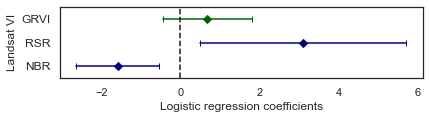

In [26]:
plot_coefficients(model_vis[::-1], photosyn_vis, moisture_vis, coeff_vals[::-1],
                  CI_low_vals[::-1], CI_high_vals[::-1], 'Model_53_logistic_coeffs_color.png')

In [27]:
accuracy = (lr.pred_table()[0,0] + lr.pred_table()[1,1]) / np.sum(lr.pred_table())
accuracy

0.8811881188118812

In [28]:
masting_df['predicted'] = np.round(lr.predict()).astype(int)

In [29]:
correct_masting = masting_df[masting_df['mast_year'] + masting_df['predicted'] == 2]
correct_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted,predicted
30,KLOO,1993,1,1,-2.301967,-0.877236,1.241432,0.432482,0.283894,-4.473623,...,0.896247,0.669041,0.886503,0.723114,0.869227,0.709907,0.910594,0.904822,1,1
46,KLOO,2010,1,1,0.183939,-1.267500,1.564651,2.533823,-0.281283,-1.572139,...,0.761742,0.976509,0.414893,0.872279,0.897865,0.918487,0.545643,0.773198,1,1
59,SILVER,2005,1,2,-0.711886,-1.330423,-0.852469,-0.725025,0.241675,-1.631459,...,0.357177,0.472675,0.401228,0.273776,0.416147,0.412262,0.273671,0.385811,0,1
77,SULPHUR,1993,1,3,-2.705765,0.178856,0.253501,0.600893,0.315982,-5.563899,...,0.977534,0.958341,0.933985,0.967139,0.930975,0.978765,0.950480,0.932822,1,1


In [30]:
missed_masting = masting_df[masting_df['mast_year'] - masting_df['predicted'] == 1]
missed_masting

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted,predicted
5,CHITTY,1998,1,0,0.227054,1.397798,0.542066,0.867753,0.817115,0.401128,...,0.308518,0.386731,0.224936,0.371604,0.263726,0.393634,0.246290,0.238539,0,0
17,CHITTY,2010,1,0,2.404857,1.333515,-0.792949,-0.344991,0.248503,1.932136,...,0.067846,0.088521,0.052684,0.236786,0.038188,0.088665,0.143436,0.050502,0,0
21,CHITTY,2014,1,0,0.354305,-0.040670,0.230459,0.097545,0.088294,0.478613,...,0.173124,0.176750,0.240170,0.198141,0.196679,0.192539,0.240186,0.212851,0,0
34,KLOO,1998,1,1,-0.066753,0.989880,0.804384,1.054669,0.769004,0.618792,...,0.199235,0.309350,0.166692,0.267686,0.231079,0.285980,0.180993,0.198350,0,0
41,KLOO,2005,1,1,-0.817383,0.210809,0.100976,-0.095338,0.269271,-0.610904,...,0.375566,0.261777,0.319020,0.211918,0.295786,0.235948,0.283498,0.310036,0,0
50,KLOO,2014,1,1,0.335624,-0.127489,0.965016,0.486863,0.189716,0.060043,...,0.255830,0.186834,0.398281,0.156268,0.333610,0.231850,0.277337,0.339311,0,0
64,SILVER,2010,1,2,-0.053022,-1.064876,-1.030085,-0.898764,0.078065,-0.496574,...,0.127510,0.190311,0.210242,0.168263,0.160413,0.197500,0.168807,0.166740,0,0
68,SILVER,2014,1,2,-0.617978,-0.619610,-1.041284,-0.955121,-0.178601,-0.831217,...,0.195901,0.174586,0.249689,0.218892,0.155580,0.223585,0.236610,0.179911,0,0
81,SULPHUR,1998,1,3,0.356217,1.314904,0.343998,0.589226,0.817719,0.355528,...,0.188217,0.181768,0.129850,0.194051,0.159776,0.198211,0.137849,0.141713,0,0
88,SULPHUR,2005,1,3,-0.574820,-0.155565,-0.202244,0.098470,0.324922,-0.396660,...,0.136526,0.220656,0.172138,0.412256,0.167105,0.261691,0.323120,0.188858,0,0


In [31]:
false_alarm = masting_df[masting_df['predicted'] - masting_df['mast_year'] == 1]
false_alarm

,site_name,year,mast_year,site_idx,grvi_slope_sds,ndvi_slope_sds,evi_slope_sds,kttc_grn_slope_sds,rsr_slope_sds,ndii_slope_sds,...,model_3_predicted,model_4_predicted,model_5_predicted,model_6_predicted,model_7_predicted,model_8_predicted,model_9_predicted,model_10_predicted,combined_model_predicted,predicted
